# Development Jupyter notebook for Student rersearch paper

This Jupyter notebook is documenting the process and test cases for the student research paper:
> *Critical clearing time of synchronous generators*

Background functions, libraries, and algorithms are not included here, as they are computed in external Python files and imported as module here. This notebook is for generating, showing and saving plots and results from these simulations.

## 1 Fundamentals and assumptions

The basic swing equations can be derived to:
$$
\frac{d\delta}{dt}=\Delta\omega\\[12pt]
\frac{d\delta}{dt}=\frac{1}{2 \cdot H_\mathrm{gen}} \cdot (P_\mathrm{m} - P_\mathrm{e})
$$
whereas $P_\mathrm{m}$ can be set to a constant value, due to the transient (short-timed) nature of fault analysis, and $P_\mathrm{e}$ can be set $0$ for a three-phase fault near the generator.

## 2 Implementation and TDS solving of the ODE system

For the solving of the ODE system, python's internal methods and functions shall be used.

### 2.1 Imports and pre-definitions

In [472]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import odeint, RK45

# helping function for calculation with complex numbers
def mag_and_angle_to_cmplx(mag, angle):
    return mag * np.exp(1j * angle)

# variable setting
fn = 60
H_gen = 3.5
X_gen = 0.2
X_ibb = 0.1
X_line = 0.65

# Values are initialized from loadflow
E_fd_gen = 1.075
E_fd_ibb = 1.033
P_m_gen = 1998/2200

omega_gen_init = 0
delta_gen_init = np.deg2rad(45.9)
delta_ibb_init = np.deg2rad(-5.0)

# simulation setups
t_start = 0
t_end = 200
t_step = 0.005

fault_start = 1
fault_end = 3.476

Defining some helping functions for determing the grid demanded electrical Power $P_\mathrm{e}$ and the mechanical power $P_\mathrm{m}$ from the Turbine.

In [473]:
def P_e(E_1, E_2, X, delta):
    P_e_gen = (E_1 * E_2) / X * np.sin(delta)
    return P_e_gen

def P_m(omega):
    global P_m_gen
    P_t = P_m_gen / (1 + omega)
    return P_m_gen

Defining / Implementing the swing equation(s), in order to solve it with `odeoint` and `RK45` functions from the package `scipy.integrate`.

In [474]:
def ODE_system(state, t):
    global H_gen
    global E_fd_gen
    global E_fd_ibb
    global X_gen
    global X_line
    global fault_start
    global fault_end

    if fault_start <= t < fault_end:
        X = 0
        E_ibb = 0
    else:
        X = X_line
        E_ibb = E_fd_ibb

    omega, delta = state
    
    d_omega_dt = 1 / (2 * H_gen) * (P_m(omega) - P_e(E_fd_gen, E_ibb, (X_gen + X), (delta)))
    d_delta_dt = omega

    return [d_omega_dt, d_delta_dt]

def rk_system(t, state):
    return ODE_system(state, t)

### 2.2 Solving with `odeint`

Simulation setup, solving and plotting of the results:

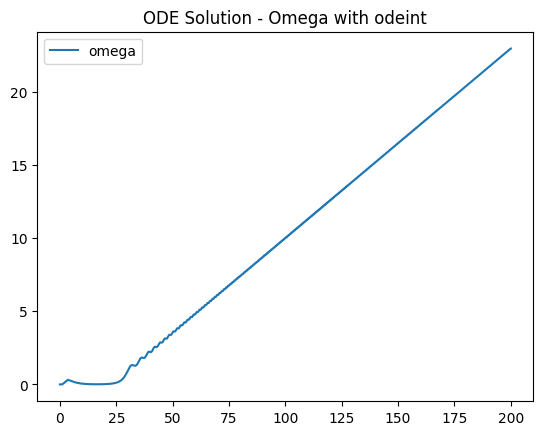

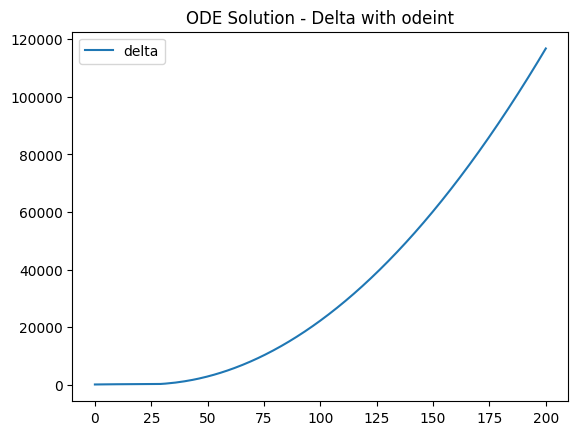

In [475]:
# setup simulation inputs 
t_sim = np.arange(t_start, t_end, t_step)
initial_conditions = [omega_gen_init, delta_gen_init]

# solve ODE with python solver
solution = odeint(ODE_system, initial_conditions, t_sim)

# save solution
omega = solution[:, 0]
delta = solution[:, 1]

# plotting of results
plt.plot(t_sim, omega, label='omega')
plt.legend()
plt.title('ODE Solution - Omega with odeint')
plt.show()

plt.plot(t_sim, np.rad2deg(delta), label='delta')
plt.legend()
plt.title('ODE Solution - Delta with odeint')
plt.show()

### 2.3 Solving with `RK45`

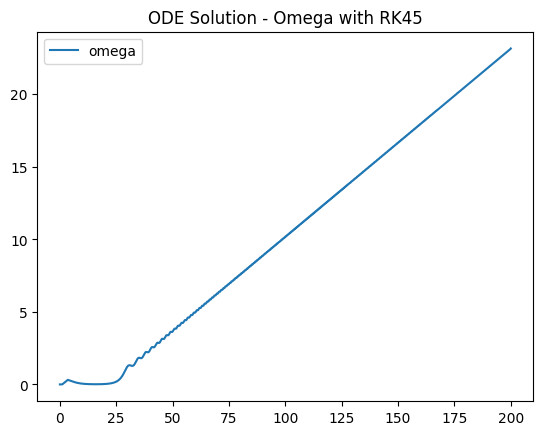

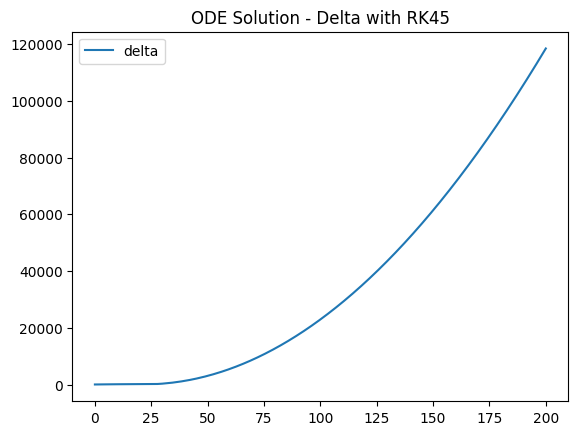

In [476]:
# same setup, solving with RK45

rk = RK45(rk_system, t_start, [omega_gen_init, delta_gen_init], t_end, max_step=t_step)

# save solution
t_rk = []
omega_rk = []
delta_rk = []

for i in range(np.size(t_sim)):
    # get solution step state
    rk.step()
    t_rk.append(rk.t)
    omega_rk.append(rk.y[0])
    delta_rk.append(rk.y[1])
    # break loop after modeling is finished
    if rk.status == 'finished':
        break

# plotting of results
plt.plot(t_rk, omega_rk, label='omega')
plt.legend()
plt.title('ODE Solution - Omega with RK45')
plt.show()

plt.plot(t_rk, np.rad2deg(delta_rk), label='delta')
plt.legend()
plt.title('ODE Solution - Delta with RK45')
plt.show()

### 2.4 Heun's method

Python does not provide this method. Following the computation of a solver for Heun's method. 

### 2.5 Comparison

Comparison between `odeint` and `RK45`:

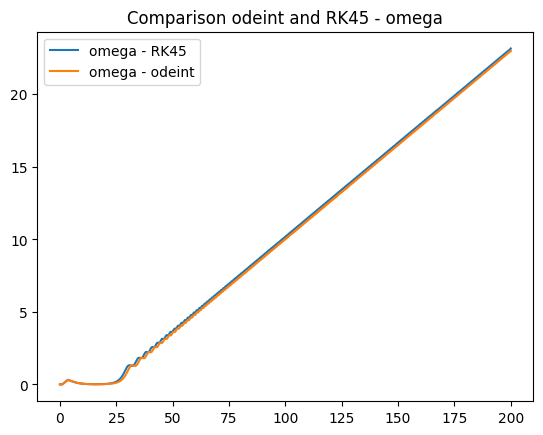

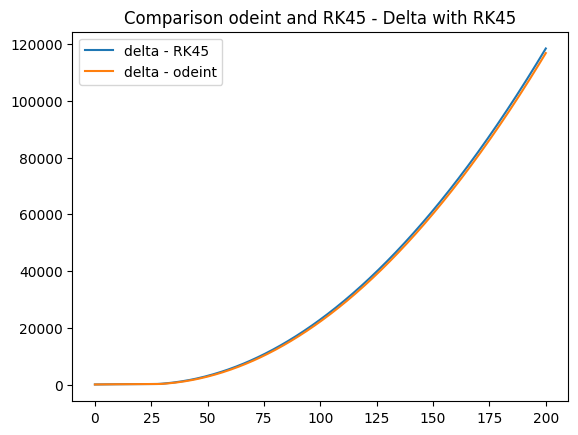

In [477]:
plt.plot(t_rk, omega_rk, label='omega - RK45')
plt.plot(t_sim, omega, label='omega - odeint')
plt.legend()
plt.title('Comparison odeint and RK45 - omega')
plt.show()

plt.plot(t_rk, np.rad2deg(delta_rk), label='delta - RK45')
plt.plot(t_sim, np.rad2deg(delta), label='delta - odeint')
plt.legend()
plt.title('Comparison odeint and RK45 - Delta with RK45')
plt.show()

**Observations:**<br>
1. No observable difference in result quality, if the max. step size is the same
2. With default `max_step=np.inf`, `RK45`-solver performs worse
3. `odeint`-solver easier to set up compared to `RK45`-solver

## 3 Implementing EAC and determing stability angle and time

In [478]:
delta_0 = delta_gen_init # later: calculation via P-delta curve
delta_max = np.pi - delta_0

def P_r_deg(x):
    # determing the P_e curve under input in degrees
    return (E_fd_gen*E_fd_ibb)/(X_gen + X_line)*np.sin(x) - P_m_gen

def P_t_deg(x):
    global omega_gen_init
    # determing the P_t curve under input in degrees
    return P_m_gen*np.ones(np.size(x))

def stability_eac(delta_0, delta_act, delta_max):
    # Compare the acceleration area until the given delta and compare it to the braking area left until the dynamic stability point is passed
    area_acc = sp.integrate.quad(P_t_deg, delta_0, delta_act)
    area_dec = sp.integrate.quad(P_r_deg, delta_act, delta_max)

    if area_acc < area_dec: # True: stable, False: NOT stable 
        return True
    else:
        return False

# Save current time and delta at time point i; iterate through i to test any given time until stability can't be remained; delta_cc and t_cc is the angle and time at the last stable point
i = 0

t_cc = -1
delta_cc = -1

while stability_eac(delta_0, delta[i], delta_max):
    t_cc = t_sim[i]
    delta_cc = delta[i]
    i = i + 1

t_cc = t_cc - fault_start

print('CCT: ' + str(t_cc) + ' s')
print('CC angle: ' + str(round(np.rad2deg(delta_cc), 2)) + ' deg')

CCT: 2.475 s
CC angle: 67.95 deg


In [479]:
# from matplotlib.patches import Polygon

# delta_c = np.rad2deg(delta_cc)
# delta_0 = np.rad2deg(delta_0)
# delta_max = np.rad2deg(delta_max)

# # calculation of P_e and P_t
# x = np.linspace(0, 180)
# y1 = (E_fd_gen*E_fd_ibb)/(X_gen + X_line)*np.sin(np.deg2rad(x))
# y2 = P_m_gen*np.ones(np.size(np.deg2rad(x)))

# # setting up the plot and plotting P_e and P_t
# fig, ax = plt.subplots()
# ax.plot(x, y1, 'r', linewidth=2, label='$P_\mathrm{e}$ of the SG')
# ax.plot(x, y2, 'b', linewidth=2, label='$P_\mathrm{T}$ of the turbine')
# ax.set_ylim(bottom=0)

# # Make the shaded region for area_acc
# ix1 = np.linspace(delta_0, delta_c)
# iy1 = P_m_gen*np.ones(np.size(ix1))
# verts = [(delta_0, 0), *zip(ix1, iy1), (delta_c, 0)]
# poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
# ax.add_patch(poly)

# # Make the shaded region for area_dec, https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html
# ix2 = np.linspace(delta_c, delta_max)
# iy2 = (E_fd_gen*E_fd_ibb)/(X_gen + X_line)*np.sin(np.deg2rad(ix2))
# ax.fill_between(ix2, iy2, P_m, facecolor='0.9', edgecolor='0.5')
# # ax.vlines(x = delta_max, ymin = 0, ymax = P_m, colors = '0.5') # vertical line for marking delta_max

# # adding area descriptions
# # ax.text(0.5*(delta_0 + delta_cc), 0.5*(P_m), r"$A_\mathrm{acc}$", horizontalalignment='center', fontsize=15)
# # ax.text(0.47*(delta_max + delta_cc), P_m+0.3*(P_max-P_m), r"$A_\mathrm{dec}$", horizontalalignment='center', fontsize=15)

# # axis text and optical manipulation of the plot
# fig.text(0.9, 0.05, '$\delta$ in $°$')
# fig.text(0.1, 0.9, '$P$ in $pu$')

# ax.spines[['top', 'right']].set_visible(False)
# ax.set_xticks([0,90,180,delta_0, delta_c, delta_max], labels=[0,90,180,'$\delta_\mathrm{0}$', '$\delta_\mathrm{c}$', '$\delta_\mathrm{max}$'])
# ax.set_yticks(np.arange(0, P_m_gen, 0.3))

# plt.legend()
# plt.show()